In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(7, 13), stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

#         self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)

#         self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
#         self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=2, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=(7, 13), stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
#         e1 = self.bn1(self.conv1(input))
#         e2 = self.bn2(self.conv2(e1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
#         e5 = self.bn5(self.conv5(e4))
#         e6 = self.conv6(e5)

#         return e6
#         print(input.shape)
#         m, indices = self.maxpool(input)
#         um = self.unpool(m, indices)
    
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
#         print(bn1.shape)
        
#         print(m3.shape)
        
#         print(um.shape)
#         print(bn1.shape)
        e2 = self.bn2(self.conv2(bn1))
#         print(e2.shape)
#         m3, indices =self.maxpool(bn1)
#         um = self.unpool(m3, indices)
        
        
#         
#         e5 = self.bn5(self.conv5(e2))
        e5 = self.bn5(self.conv5(e2))
#         print(e5.shape)
        e6 = self.conv6(e5)
#         print(e6.shape)

        return e6



In [18]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

model = Net()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

num_folds = 5
fold_num = 0
origin_train, origin_test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

train_residual = origin_train[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
train = np.hstack((origin_train, train_residual))

# create the residual column
test_residual = origin_test[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
test = np.hstack((origin_test, test_residual))

APPLIANCE_ORDER=['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw', 'residual']

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [19]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [22]:
model = Net()

loss_fn = nn.L1Loss()
# loss_fun = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('residual') 
print(app_idx)
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

6


In [23]:

for epoch in range(20000):
    
    pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %100 == 0:
        
        
        test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])
#         print(test_pr.max())

0 Training Error: 1107.90478515625 Test Error: 942.8123779296875
100 Training Error: 1107.617431640625 Test Error: 942.6156616210938
200 Training Error: 1106.6246337890625 Test Error: 941.6090698242188
300 Training Error: 1098.1065673828125 Test Error: 932.8621215820312
400 Training Error: 1024.0626220703125 Test Error: 857.8959350585938
500 Training Error: 793.15966796875 Test Error: 627.208251953125
600 Training Error: 592.7005615234375 Test Error: 468.39141845703125
700 Training Error: 529.8377075195312 Test Error: 424.2123107910156
800 Training Error: 514.2713012695312 Test Error: 413.1302490234375
900 Training Error: 512.8912353515625 Test Error: 414.4805603027344
1000 Training Error: 477.9426574707031 Test Error: 411.7440490722656
1100 Training Error: 476.2970275878906 Test Error: 400.2404479980469
1200 Training Error: 461.1650390625 Test Error: 399.10943603515625
1300 Training Error: 450.9068298339844 Test Error: 388.5707702636719
1400 Training Error: 452.6343994140625 Test Erro

11900 Training Error: 249.18443298339844 Test Error: 344.4062805175781
12000 Training Error: 248.85379028320312 Test Error: 339.593017578125
12100 Training Error: 248.63601684570312 Test Error: 342.51837158203125
12200 Training Error: 246.37612915039062 Test Error: 340.75408935546875
12300 Training Error: 246.41201782226562 Test Error: 341.12646484375
12400 Training Error: 247.7349395751953 Test Error: 336.7911682128906
12500 Training Error: 246.44268798828125 Test Error: 342.7543029785156
12600 Training Error: 246.22531127929688 Test Error: 339.6431884765625
12700 Training Error: 245.71144104003906 Test Error: 341.924560546875
12800 Training Error: 246.4979705810547 Test Error: 335.42474365234375
12900 Training Error: 247.13563537597656 Test Error: 339.2651062011719
13000 Training Error: 245.30825805664062 Test Error: 339.08367919921875
13100 Training Error: 243.91635131835938 Test Error: 337.9312438964844
13200 Training Error: 244.3699951171875 Test Error: 342.25726318359375
13300 Tr

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [25]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

In [26]:
test[:, 6, :, :].shape

(14, 112, 24)

14


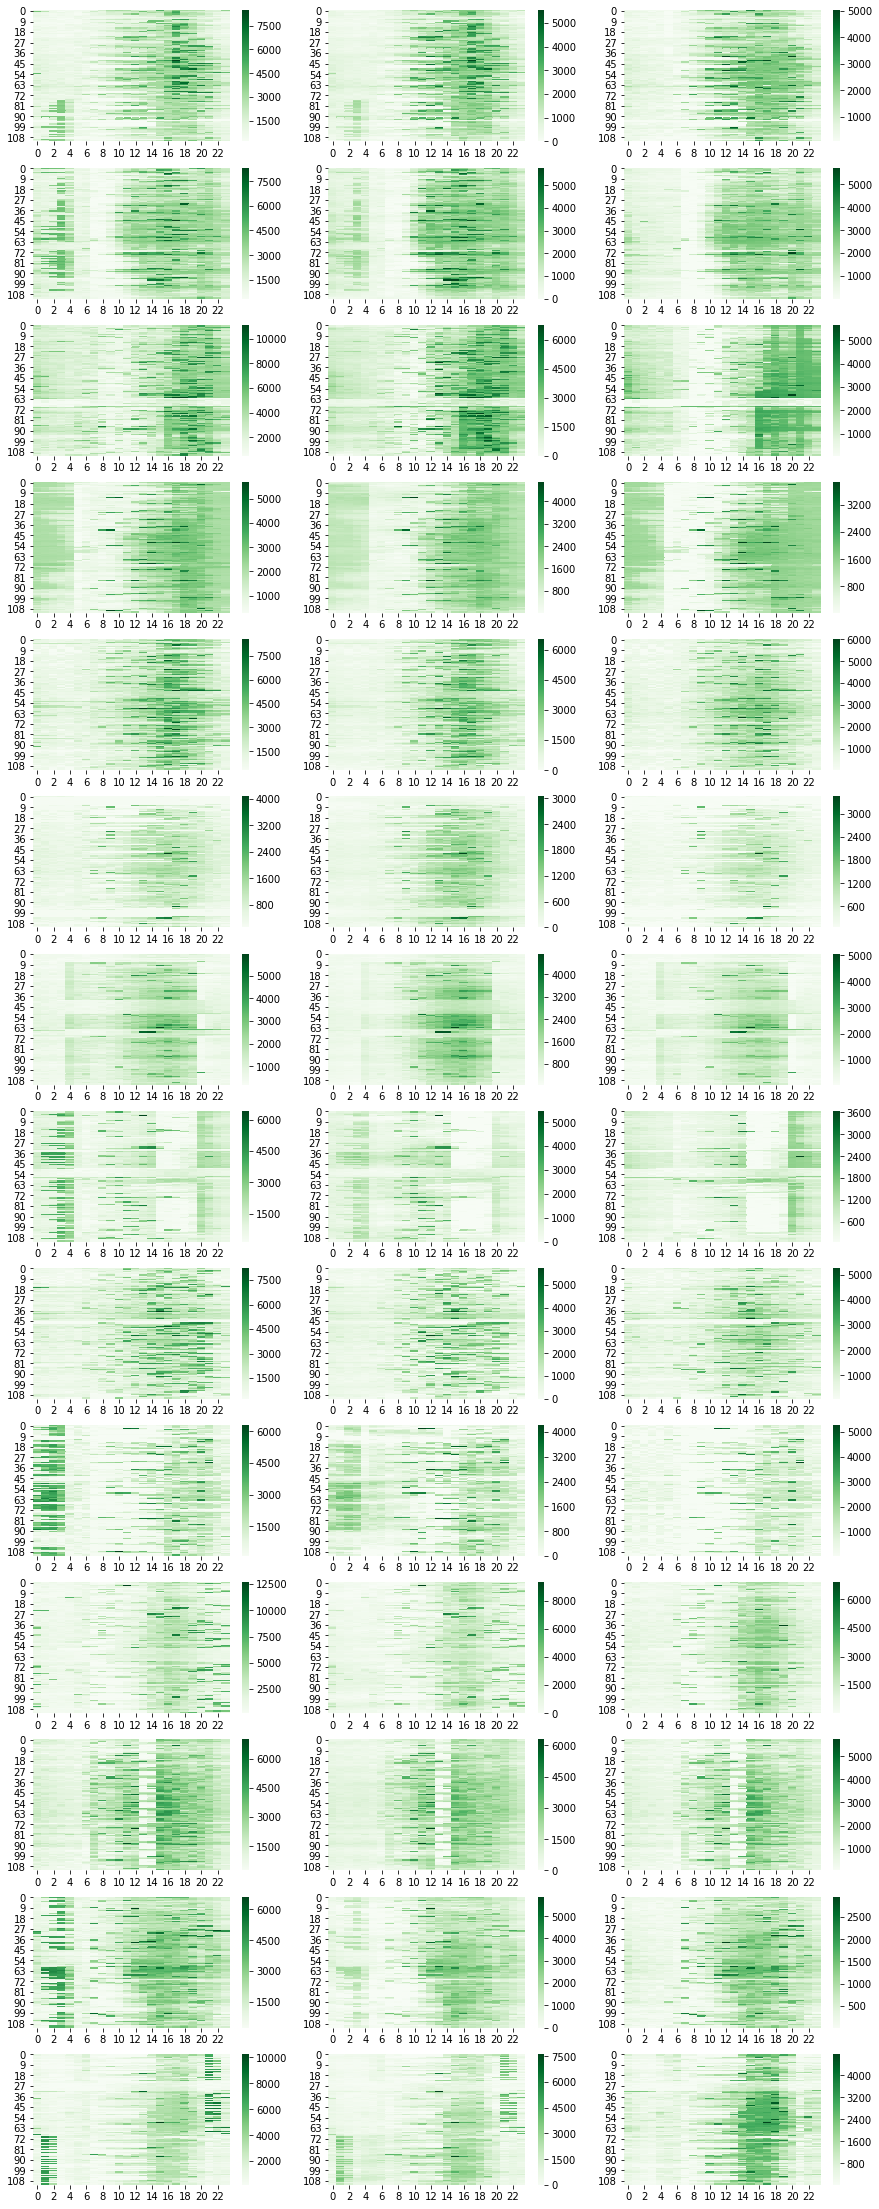

In [27]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




In [ ]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




43


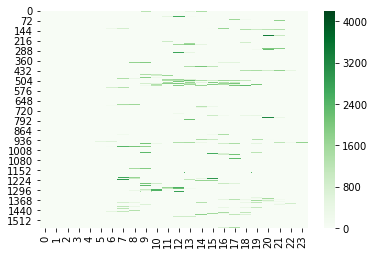

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')